## Table of Contents
- [Loading cleaned dataset](#section1)
- [(Normal) Splitting dataset (train, val, test)](#section2)
- [(Spatial) Splitting dataset (train, val, test)](#section3)
- [Creating new features based on pca](#section4)
- [Encoding categorical features + target feature ](#section5)
- [Feature Selection](#section6)
- [Baseline_model (KNN)](#section7)
- [Baseline_model Random_forest](#section8)
- [Baseline_model eXtreme Gradient Boosting (xgb)](#section9)
- [Baseline_nodel TabNet](#section10)
- [Prediction based on test data](#section11)
- [Classification_report + metrics](#section12)
- [Feature_Importance_RF+XGB_TabNet](#section13)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import torch
import joblib
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score,confusion_matrix, classification_report
np.random.seed(10)
from xgboost import XGBClassifier
import geopandas as gpd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

<a id='section1'></a>
# Loading cleaned dataset 
[Back to Table of Contents](#Table-of-Contents)

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("df_no_correlation.csv")
df.head(2)
df.shape

(164364, 35)

<a id='section2'></a>
# (Normal) Splitting dataset (train, val, test)
[Back to Table of Contents](#Table-of-Contents)

In [3]:
# split dataset into train,test 
# Extract features and target variable
X = df.drop(columns=['TransportMode'])
y = df['TransportMode']

#  Extract groups ('UniqueIdentifier')
groups = X['UniqueIdentifier']

# Stratified Group K-Fold
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=0) 

# Stratified Group K-Fold splitting
for train_index, test_index in sgkf.split(X, y, groups):
    X_train_random, X_test_random = X.iloc[train_index], X.iloc[test_index]
    y_train_random, y_test_random = y.iloc[train_index], y.iloc[test_index]


In [4]:
# split training into train, val
# Extract groups ('UniqueIdentifier')
groups = X_train_random['UniqueIdentifier']

# Stratified Group K-Fold
sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=0) 

# Stratified Group K-Fold splitting
for train_index, val_index in sgkf.split(X_train_random, y_train_random, groups):
    X_train_fold_random, X_val_fold_random = X_train_random.iloc[train_index], X_train_random.iloc[val_index]
    y_train_fold_random, y_val_fold_random = y_train_random.iloc[train_index], y_train_random.iloc[val_index]
        

In [5]:
print(X_test_random.shape)
print(X_train_fold_random.shape)
print(X_val_fold_random.shape)

(55012, 34)
(72653, 34)
(36699, 34)


<a id='section3'></a>
# (Spatial) Splitting dataset (train, val, test)
[Back to Table of Contents](#Table-of-Contents)

In [6]:
# split dataset into train,val
# Extract groups 'Residential Municipality'
# features and target variable
X = df.drop(columns=['TransportMode'])
y = df['TransportMode']

# Extract groups 'Residential Municipality'
groups = X['Residential Municipality']

# Stratified Group K-Fold for train/test split
sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=0) 

# Stratified Group K-Fold splitting for train/test split
for train_index, test_index in sgkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [7]:
# split training into train, test
# Extract groups 'Residential Municipality'
groups_train = X_train['Residential Municipality']

# Stratified Group K-Fold for train/test split
sgkf_test = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=0)

# Stratified Group K-Fold splitting for train/test split
for train_index, val_index in sgkf_test.split(X_train, y_train, groups_train):
    X_train_split, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val = y_train.iloc[train_index], y_train.iloc[val_index]


In [8]:
print(X_test.shape)
print(X_train_split.shape)
print(X_val.shape)

(34282, 34)
(95473, 34)
(34609, 34)


In [9]:
training_percentage = str((X_train_split.shape[0] /df.shape[0]) * 100) + " %"
validation_percentage = str((X_val.shape[0] / df.shape[0]) * 100) + " %"
test_percentage = str((X_test.shape[0] / df.shape[0]) * 100) + " %"

print("Training set percentage:", training_percentage)
print("Validation set percentage:", validation_percentage)
print("Test set percentage:", test_percentage)

Training set percentage: 58.08632060548538 %
Validation set percentage: 21.056314034703462 %
Test set percentage: 20.85736535981115 %


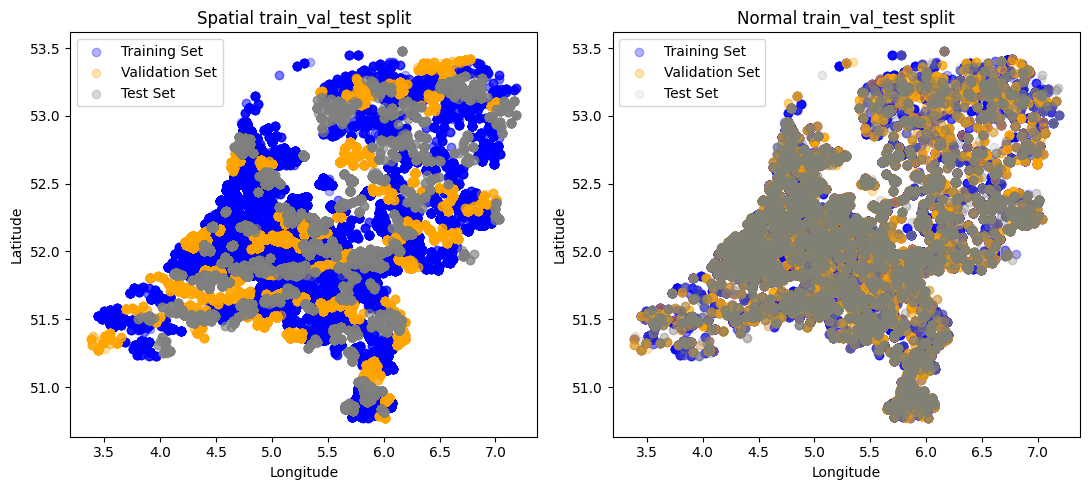

In [10]:
# visualization: spatial split vs random split
plt.figure(figsize=(11, 5))
plt.subplot(121)

plt.scatter(X_train_split['LongitudeLiving'], X_train_split['LatitudeLiving'], color='blue', label='Training Set', alpha=0.3)
plt.scatter(X_val['LongitudeLiving'], X_val['LatitudeLiving'], color='orange', label='Validation Set',alpha=0.3)
plt.scatter(X_test['LongitudeLiving'], X_test['LatitudeLiving'], color='gray', label='Test Set',alpha=0.3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial train_val_test split')
plt.legend()

plt.subplot(122)
plt.scatter(X_train_fold_random['LongitudeLiving'], X_train_fold_random['LatitudeLiving'], color='blue', label='Training Set',alpha=0.3)
plt.scatter(X_val_fold_random['LongitudeLiving'], X_val_fold_random['LatitudeLiving'], color='orange', label='Validation Set',alpha=0.3)
plt.scatter(X_test_random['LongitudeLiving'], X_test_random['LatitudeLiving'], color='gray', label='Test Set',alpha=0.09)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Normal train_val_test split')

plt.tight_layout()
plt.legend()
plt.savefig('train_val_test_split', bbox_inches='tight')
plt.show()

<a id='section4'></a>
# Creating new features based on pca
[Back to Table of Contents](#Table-of-Contents)

In [11]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA


scaler = RobustScaler()
X_train_split_scaled = scaler.fit_transform(X_train_split[['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving']])
X_val_scaled = scaler.transform(X_val[['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving']])
X_test_scaled = scaler.transform(X_test[['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving']])


pca = PCA()
pca.fit(X_train_split_scaled)  


X_train_split_pca = pca.transform(X_train_split_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


for i in range(pca.n_components_):
    X_train_split[f'PCA_dr_wl_cl_duration_{i+1}'] = X_train_split_pca[:, i]
    X_val[f'PCA_dr_wl_cl_duration_{i+1}'] = X_val_pca[:, i]
    X_test[f'PCA_dr_wl_cl_duration_{i+1}'] = X_test_pca[:, i]


X_train_split.drop(['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving'], inplace=True, axis=1)
X_val.drop(['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving'], inplace=True, axis=1)
X_test.drop(['Duration_by_foot', 'Duration_by_cycling', 'Duration_by_driving'], inplace=True, axis=1)


X_test.to_csv("X_test.csv")
X_train_split.to_csv("X_train_split.csv")
X_val.to_csv("X_val.csv")


In [12]:
pca.explained_variance_ratio_

array([0.99312836, 0.00490974, 0.00196189])

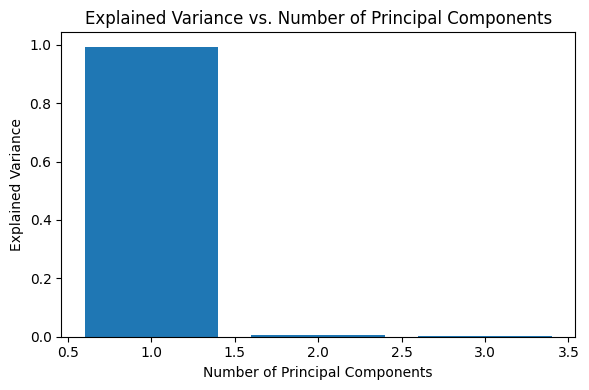

In [13]:
# part of this code is from: https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

plt.tight_layout()
plt.savefig('pca', bbox_inches='tight')
plt.show()


In [14]:
# save it for later use
X_train_region = X_train_split[["Residential Municipality", "ResidentialProvince"]]
X_test_region = X_test[["Residential Municipality", "ResidentialProvince"]]
X_val_region= X_val[["Residential Municipality", "ResidentialProvince"]]


X_train_region.to_csv('X_train_region.csv', index=False)
X_test_region.to_csv('X_test_region.csv', index=False)
X_val_region.to_csv('X_val_region.csv', index=False)


In [15]:
# drop columns not needed for the prediction
X_test.drop(["UniqueIdentifier", "HomePostalCode", 'Residential Municipality', "ResidentialProvince"], inplace = True,axis = 1)
X_train_split.drop(["UniqueIdentifier", "HomePostalCode",'Residential Municipality', "ResidentialProvince"], inplace = True,axis = 1)
X_val.drop(["UniqueIdentifier", "HomePostalCode",'Residential Municipality', "ResidentialProvince"], inplace = True,axis = 1)

In [16]:
print(X_test.shape)
print(X_train_split.shape)
print(X_val.shape)

(34282, 30)
(95473, 30)
(34609, 30)


<a id='section5'></a>
# Encoding categorical features + target feature 
[Back to Table of Contents](#Table-of-Contents)

In [17]:
# part of this code is from https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b#:~:text=Ordinal%20encoding%20is%20similar%20to,map%20them%20to%20integers%20accordingly.
from sklearn.preprocessing import OrdinalEncoder


educ_order = ["Low", "Medium","High"]
educ_encoder = OrdinalEncoder(categories=[educ_order])
X_train_split["EducationLevel"] = educ_encoder.fit_transform(X_train_split[["EducationLevel"]]).flatten()
X_val["EducationLevel"] = educ_encoder.transform(X_val[["EducationLevel"]]).flatten()
X_test["EducationLevel"] = educ_encoder.transform(X_test[["EducationLevel"]]).flatten()

In [18]:
np.unique(df["FrequencyOfWalkingOutdoors"])

array(['Daily or almost daily', 'Never or almost never',
       'Several times a month', 'Several times a week',
       'Several times a year'], dtype=object)

In [19]:
ordinal_order = [ 'Never or almost never', 'Several times a year',
       'Several times a month', 'Several times a week',
       'Daily or almost daily']

ourdoor_encoder = OrdinalEncoder(categories=[ordinal_order])
X_train_split["FrequencyOfWalkingOutdoors"] = ourdoor_encoder.fit_transform(X_train_split[["FrequencyOfWalkingOutdoors"]]).flatten()
X_val["FrequencyOfWalkingOutdoors"] = ourdoor_encoder.transform(X_val[["FrequencyOfWalkingOutdoors"]]).flatten()
X_test["FrequencyOfWalkingOutdoors"] = ourdoor_encoder.transform(X_test[["FrequencyOfWalkingOutdoors"]]).flatten()

pass_encoder = OrdinalEncoder(categories=[ordinal_order])
X_train_split["FrequencyOfUseCcarAsAPassenger"] = pass_encoder.fit_transform(X_train_split[["FrequencyOfUseCcarAsAPassenger"]]).flatten()
X_val["FrequencyOfUseCcarAsAPassenger"] = pass_encoder.transform(X_val[["FrequencyOfUseCcarAsAPassenger"]]).flatten()
X_test["FrequencyOfUseCcarAsAPassenger"] = pass_encoder.transform(X_test[["FrequencyOfUseCcarAsAPassenger"]]).flatten()

non_elec_encoder = OrdinalEncoder(categories=[ordinal_order])
X_train_split["FrequencyOfUseOfNonEelectricBicycle"] = non_elec_encoder.fit_transform(X_train_split[["FrequencyOfUseOfNonEelectricBicycle"]]).flatten()
X_val["FrequencyOfUseOfNonEelectricBicycle"] = non_elec_encoder.transform(X_val[["FrequencyOfUseOfNonEelectricBicycle"]]).flatten()
X_test["FrequencyOfUseOfNonEelectricBicycle"] = non_elec_encoder.transform(X_test[["FrequencyOfUseOfNonEelectricBicycle"]]).flatten()

In [20]:
household_order = ['1', '2', '3', '4', '5 or more']
household_encoder = OrdinalEncoder(categories=[household_order])
X_train_split["HouseholdSize"] = household_encoder.fit_transform(X_train_split[["HouseholdSize"]]).flatten()
X_val["HouseholdSize"] = household_encoder.transform(X_val[["HouseholdSize"]]).flatten()
X_test["HouseholdSize"] = household_encoder.transform(X_test[["HouseholdSize"]]).flatten()


In [21]:
age_order = ['6 to 11 years', '12 to 14 years', '15 to 17 years', '18 to 19 years', '20 to 24 years', '25 to 29 years',
             '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years',
             '60 to 64 years', '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 years or older']

age_encoder = OrdinalEncoder(categories=[age_order])

X_train_split["AgeClass"] = age_encoder.fit_transform(X_train_split[["AgeClass"]]).flatten()
X_val["AgeClass"] = age_encoder.transform(X_val[["AgeClass"]]).flatten()
X_test["AgeClass"] = age_encoder.transform(X_test[["AgeClass"]]).flatten()


In [22]:
cars_order = ['0', '1', '2', '3', '4 or more']
cars_encoder = OrdinalEncoder(categories=[cars_order])
X_train_split["NumberOfCarsInHousehold"] = cars_encoder.fit_transform(X_train_split[["NumberOfCarsInHousehold"]]).flatten()
X_val["NumberOfCarsInHousehold"] = cars_encoder.transform(X_val[["NumberOfCarsInHousehold"]]).flatten()
X_test["NumberOfCarsInHousehold"] = cars_encoder.transform(X_test[["NumberOfCarsInHousehold"]]).flatten()


In [23]:
income_order = ['First 10% group','Second 10% group','Third 10% group','Fourth 10% group','Fifth 10% group',
               'Sixth 10% group','Seventh 10% group','Eighth 10% group','Ninth 10% group','Tenth 10% group',]

income_encoder = OrdinalEncoder(categories=[income_order])

X_train_split["DisposableIncome"] = income_encoder.fit_transform(X_train_split[["DisposableIncome"]]).flatten()
X_val["DisposableIncome"] = income_encoder.transform(X_val[["DisposableIncome"]]).flatten()
X_test["DisposableIncome"] = income_encoder.transform(X_test[["DisposableIncome"]]).flatten()

In [24]:
# convert gender into binary 
X_train_split["Weekday"].replace({"weekday": 1, "weekend": 0}, inplace=True)
X_test["Weekday"].replace({"weekday": 1, "weekend": 0}, inplace=True)
X_val["Weekday"].replace({"weekday": 1, "weekend": 0}, inplace=True)


X_train_split["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)
X_test["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)
X_val["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)

X_train_split["License"].replace({"Yes": 1, "No": 0}, inplace=True)
X_test["License"].replace({"Yes": 1, "No": 0}, inplace=True)
X_val["License"].replace({"Yes": 1, "No": 0}, inplace=True)


X_train_split["ElectriBicycleIHousehold"].replace({"Yes": 1, "No": 0}, inplace=True)
X_test["ElectriBicycleIHousehold"].replace({"Yes": 1, "No": 0}, inplace=True)
X_val["ElectriBicycleIHousehold"].replace({"Yes": 1, "No": 0}, inplace=True)


In [25]:
ordinal_features = ["AgeClass","HouseholdSize", "DisposableIncome","FrequencyOfUseOfNonEelectricBicycle", "FrequencyOfWalkingOutdoors",
                    "NumberOfCarsInHousehold",  "EducationLevel","FrequencyOfUseCcarAsAPassenger"]
numeric_features = [ "TotalTravelDuration", "DepartureTime","NumberOfTripLegs"
                    , "NumBusStops", 'RoadNetworkDensity','AvgDistToTrainStation',"TripLegDistance","N.OFHouseholdMemberUnd6",
    'AvgDistToSupermarket', 'NofBusinessEstablishments', 'SurroundingAddressDensity', "LatitudeLiving", "LongitudeLiving"]
categorical_features = ["TripPurpose","WorkCommuteReimbursement", ]
binary_features = ["Gender","License", "Weekday", "ElectriBicycleIHousehold"]
pca_features = ["PCA_dr_wl_cl_duration_2","PCA_dr_wl_cl_duration_1", "PCA_dr_wl_cl_duration_3"]
len(ordinal_features) + len(numeric_features) + len(categorical_features) + len(binary_features) + len(pca_features)

30

In [26]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Define all_features variable
all_features = ordinal_features + numeric_features + categorical_features + binary_features + pca_features 

# Scale numerical features only (excluding ordinal features)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_split[numeric_features])
X_val_scaled = scaler.transform(X_val[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# One-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(X_train_split[categorical_features])
one_hot_feature_names = encoder.get_feature_names_out(input_features=categorical_features)

X_train_cat_encoded = encoder.transform(X_train_split[categorical_features])
X_val_cat_encoded = encoder.transform(X_val[categorical_features])
X_test_cat_encoded = encoder.transform(X_test[categorical_features])

# Concatenate encoded categorical features with binary features
X_train_encoded = np.concatenate([X_train_cat_encoded, X_train_split[binary_features]], axis=1)
X_val_encoded = np.concatenate([X_val_cat_encoded, X_val[binary_features]], axis=1)
X_test_encoded = np.concatenate([X_test_cat_encoded, X_test[binary_features]], axis=1)

# Concatenate scaled numerical features with encoded categorical and binary features, and PCA features
X_train_final = np.concatenate([X_train_scaled, X_train_encoded, X_train_split[ordinal_features], 
                                 X_train_split[["PCA_dr_wl_cl_duration_2", "PCA_dr_wl_cl_duration_1", "PCA_dr_wl_cl_duration_3"]].values], axis=1)

X_val_final = np.concatenate([X_val_scaled, X_val_encoded, X_val[ordinal_features], 
                               X_val[["PCA_dr_wl_cl_duration_2", "PCA_dr_wl_cl_duration_1", "PCA_dr_wl_cl_duration_3"]].values], axis=1)

X_test_final = np.concatenate([X_test_scaled, X_test_encoded, X_test[ordinal_features], 
                                X_test[["PCA_dr_wl_cl_duration_2", "PCA_dr_wl_cl_duration_1", "PCA_dr_wl_cl_duration_3"]].values], axis=1)

# Combine all feature names
all_feature_names = numeric_features + list(one_hot_feature_names) + binary_features + ordinal_features + pca_features 

# Write feature names to a text file
with open("all_feature_names.txt", "w") as f:
    for s in all_feature_names:
        f.write(str(s) + "\n")


In [27]:
from sklearn import preprocessing
# encoding target feature
le = preprocessing.LabelEncoder()

# Fit encoder on train set
y_train_split = le.fit_transform(y_train_split)

# Use fitted encoder to transform the test set
y_test = le.transform (y_test)

y_val = le.transform (y_val)

np.savetxt('y_train_split_encoded.txt', y_train_split, fmt='%d')
np.savetxt('y_val_encoded.txt', y_val, fmt='%d')
np.savetxt('y_test_encoded.txt', y_test, fmt='%d')

In [28]:
len(all_feature_names)

35

In [30]:
all_feature_names

['TotalTravelDuration',
 'DepartureTime',
 'NumberOfTripLegs',
 'NumBusStops',
 'RoadNetworkDensity',
 'AvgDistToTrainStation',
 'TripLegDistance',
 'N.OFHouseholdMemberUnd6',
 'AvgDistToSupermarket',
 'NofBusinessEstablishments',
 'SurroundingAddressDensity',
 'LatitudeLiving',
 'LongitudeLiving',
 'TripPurpose_Leisure Activities',
 'TripPurpose_Maintenance Activities',
 'TripPurpose_Other motive',
 'TripPurpose_Subsistence Activities',
 'WorkCommuteReimbursement_No reimbursement',
 'WorkCommuteReimbursement_Not applicable',
 'WorkCommuteReimbursement_Reimbursement provided',
 'Gender',
 'License',
 'Weekday',
 'ElectriBicycleIHousehold',
 'AgeClass',
 'HouseholdSize',
 'DisposableIncome',
 'FrequencyOfUseOfNonEelectricBicycle',
 'FrequencyOfWalkingOutdoors',
 'NumberOfCarsInHousehold',
 'EducationLevel',
 'FrequencyOfUseCcarAsAPassenger',
 'PCA_dr_wl_cl_duration_2',
 'PCA_dr_wl_cl_duration_1',
 'PCA_dr_wl_cl_duration_3']

<a id='section6'></a>
# Feature Selection
[Back to Table of Contents](#Table-of-Contents)

In [ ]:
# part of this code if from: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

min_features_to_select = 1 
clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='f1_macro',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train_final, y_train_split)

print(f"Optimal number of features: {rfecv.n_features_}")


In [ ]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test f1_macro")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.tight_layout()  
plt.savefig("RFE.pdf")
plt.show()


In [ ]:
selected_feature_rfecv = np.array(all_feature_names)[rfecv.support_]

with open("selected_feature_rfecv.txt", "w") as f:
    for s in selected_feature_rfecv:
        f.write(str(s) + "\n")
len(selected_feature_rfecv)
selected_feature_rfecv

In [46]:
with open('all_feature_names.txt', 'r') as file:
    all_feature_names = [line.strip() for line in file]

print(all_feature_names)


['TotalTravelDuration', 'DepartureTime', 'NumberOfTripLegs', 'NumBusStops', 'RoadNetworkDensity', 'AvgDistToTrainStation', 'TripLegDistance', 'N.OFHouseholdMemberUnd6', 'AvgDistToSupermarket', 'NofBusinessEstablishments', 'SurroundingAddressDensity', 'LatitudeLiving', 'LongitudeLiving', 'TripPurpose_Leisure Activities', 'TripPurpose_Maintenance Activities', 'TripPurpose_Other motive', 'TripPurpose_Subsistence Activities', 'WorkCommuteReimbursement_No reimbursement', 'WorkCommuteReimbursement_Not applicable', 'WorkCommuteReimbursement_Reimbursement provided', 'Gender', 'License', 'Weekday', 'ElectriBicycleIHousehold', 'ChildrenUn6IncludedInThetravel', 'Holiday', 'AgeClass', 'HouseholdSize', 'DisposableIncome', 'FrequencyOfUseOfNonEelectricBicycle', 'FrequencyOfWalkingOutdoors', 'NumberOfCarsInHousehold', 'EducationLevel', 'InhabitantClass', 'FrequencyOfUseCcarAsAPassenger', 'PCA_dr_wl_cl_duration_2', 'PCA_dr_wl_cl_duration_1', 'PCA_dr_wl_cl_duration_3']


In [5]:
selected_feature_rfecv = ['TotalTravelDuration', 'DepartureTime','NumberOfTripLegs', 'NumBusStops', 'RoadNetworkDensity',
 'AvgDistToTrainStation', 'TripLegDistance', 'N.OFHouseholdMemberUnd6', 'AvgDistToSupermarket',
 'NofBusinessEstablishments', 'SurroundingAddressDensity', 'LatitudeLiving', 'LongitudeLiving',
 'TripPurpose_Leisure Activities','TripPurpose_Maintenance Activities', 'TripPurpose_Other motive',
 'TripPurpose_Subsistence Activities','WorkCommuteReimbursement_No reimbursement', 'WorkCommuteReimbursement_Not applicable',
 'WorkCommuteReimbursement_Reimbursement provided','Gender','License', 'Weekday','ElectriBicycleIHousehold',
 'AgeClass','HouseholdSize', 'DisposableIncome', 'FrequencyOfUseOfNonEelectricBicycle',
 'FrequencyOfWalkingOutdoors', 'NumberOfCarsInHousehold', 'EducationLevel', 'FrequencyOfUsecarAsAPassenger', 'PCA_dr_wl_cl_duration_2',
 'PCA_dr_wl_cl_duration_1','PCA_dr_wl_cl_duration_3']
len(selected_feature_rfecv)

35

In [50]:
# not selected features
nt = []

for i in all_feature_names: 
    if i not in selected_feature_rfecv: 
        nt.append(i)
nt

[]

In [51]:
# select top features and match with train, test, val dataset
top_mi_features = list(selected_feature_rfecv)

feature_indices = [all_feature_names.index(feature) for feature in top_mi_features]


X_train_top_mi = X_train_final[:, feature_indices]

feature_indices = [all_feature_names.index(feature) for feature in top_mi_features]


X_val_top_mi = X_val_final[:, feature_indices]


X_test_top_mi = X_test_final[:, feature_indices]

# save the data
np.savetxt('X_train_top_mi.txt', X_train_top_mi, delimiter=',')
np.savetxt('X_val_top_mi.txt', X_val_top_mi, delimiter=',')
np.savetxt('X_test_top_mi.txt', X_test_top_mi, delimiter=',')

In [8]:
# Load the X_data
X_train_top_mi = np.loadtxt('X_train_top_mi.txt', delimiter=',')
X_val_top_mi = np.loadtxt('X_val_top_mi.txt', delimiter=',')
X_test_top_mi = np.loadtxt('X_test_top_mi.txt', delimiter=',')

# load the y_data
y_train_split = np.loadtxt('y_train_split_encoded.txt', dtype=int)
y_val = np.loadtxt('y_val_encoded.txt', dtype=int)
y_test = np.loadtxt('y_test_encoded.txt', dtype=int)

In [9]:
print(X_train_top_mi.shape)
print(X_test_top_mi.shape)
print(X_val_top_mi.shape)


print(y_train_split.shape)
print(y_test.shape)
print(y_val.shape)

(95473, 35)
(34282, 35)
(34609, 35)
(95473,)
(34282,)
(34609,)


<a id='section7'></a>
# Baseline_model (KNN)
[Back to Table of Contents](#Table-of-Contents)

In [10]:
from functions_baseline import Objective_knn, Objective_rf, Objective_xgb, Objective_tabnet, all_metrics, predict, conf_matrix
import optuna

In [67]:
import joblib

random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_knn(trial, X_train_top_mi, y_train_split, X_val_top_mi, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_knn.pkl')

best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 20:07:41,707] A new study created in memory with name: no-name-e7cbd813-3ea3-416b-a5b0-1cb57af70e5f
[I 2024-04-28 20:07:45,500] Trial 0 finished with value: 0.5606766730631904 and parameters: {'n_neighbors': 283, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 0 with value: 0.5606766730631904.
[I 2024-04-28 20:07:49,151] Trial 1 finished with value: 0.560591154783071 and parameters: {'n_neighbors': 280, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 0 with value: 0.5606766730631904.
[I 2024-04-28 20:17:16,297] Trial 2 finished with value: 0.5546637606314869 and parameters: {'n_neighbors': 311, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.5606766730631904.
[I 2024-04-28 20:17:32,290] Trial 3 finished with value: 0.56374032657299 and parameters: {'n_neighbors': 257, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'brute'}. Best is trial 3 

Best Score:  0.6068224680116613
Best Params: 
  n_neighbors: 277
  weights: distance
  metric: manhattan
  algorithm: brute


<a id='section8'></a>
 # Baseline_model Random_forest
[Back to Table of Contents](#Table-of-Contents)

In [66]:
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_rf(trial, X_train_top_mi, y_train_split, X_val_top_mi, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_rf.pkl')


best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 20:00:06,416] A new study created in memory with name: no-name-0ae8baf0-8e90-4f97-ae82-b3976be7dcb4
[I 2024-04-28 20:00:08,037] Trial 0 finished with value: 0.7205487051068171 and parameters: {'n_estimators': 7, 'max_depth': 36, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.7205487051068171.
[I 2024-04-28 20:00:08,912] Trial 1 finished with value: 0.7034524853071666 and parameters: {'n_estimators': 4, 'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.7205487051068171.
[I 2024-04-28 20:00:10,530] Trial 2 finished with value: 0.689200729041935 and parameters: {'n_estimators': 1, 'max_depth': 29, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7205487051068171.
[I 2024-04-28 20:00:11,457] Trial 3 finished with value: 0.7166719833489333 and parameters

Best Score:  0.7580287761299398
Best Params: 
  n_estimators: 105
  max_depth: 24
  min_samples_leaf: 7
  max_features: None
  bootstrap: True
  criterion: entropy


https://link-springer-com.tilburguniversity.idm.oclc.org/article/10.1007/s11042-024-18426-2#Tab6

<a id='section9'></a>
# Baseline_model eXtreme Gradient Boosting (xgb)
[Back to Table of Contents](#Table-of-Contents)

In [55]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_xgb(trial, X_train_top_mi, y_train_split, X_val_top_mi, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_xgb.pkl')

# print the best scores for each trial 
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 18:43:08,330] A new study created in memory with name: no-name-cadabbee-ece0-4017-9019-6fd798c1baa0
[I 2024-04-28 18:43:25,604] Trial 0 finished with value: 0.7736450897581267 and parameters: {'learning_rate': 0.29132443978979455, 'n_estimators': 698, 'max_depth': 16, 'min_child_weight': 77.24534209102481, 'gamma': 0.042730351134688926, 'subsample': 0.8039352037633734, 'colsample_bytree': 0.3528692177294338, 'reg_alpha': 12.971531129600407, 'reg_lambda': 18.362970750513192}. Best is trial 0 with value: 0.7736450897581267.
[I 2024-04-28 18:43:34,177] Trial 1 finished with value: 0.7779973185109933 and parameters: {'learning_rate': 0.19606864782715086, 'n_estimators': 524, 'max_depth': 5, 'min_child_weight': 96.41853885567953, 'gamma': 0.47215091499160244, 'subsample': 0.5402702770785732, 'colsample_bytree': 0.5942690753173899, 'reg_alpha': 13.036682473925929, 'reg_lambda': 25.586745856532005}. Best is trial 1 with value: 0.7779973185109933.
[I 2024-04-28 18:44:03,586] Tria

Best Score:  0.7806901353904756
Best Params: 
  learning_rate: 0.11035472913773701
  n_estimators: 993
  max_depth: 10
  min_child_weight: 166.33677387889497
  gamma: 0.6970463624426666
  subsample: 0.8682517336083143
  colsample_bytree: 0.7445228268335462
  reg_alpha: 7.639114789998363
  reg_lambda: 13.554907113097677


<a id='section10'></a>
# Baseline_nodel TabNet
[Back to Table of Contents](#Table-of-Contents)

In [65]:
import optuna
random_state = 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=1, reduction_factor=3)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(lambda trial: Objective_tabnet(trial, X_train_top_mi, y_train_split, X_val_top_mi, y_val), n_trials=20)

# Save the study for later use
joblib.dump(study, 'study_tabnet.pkl')

# Retrieve the best trial and print its score and parameters
best_trial = study.best_trial
print("Best Score: ", best_trial.value)
print("Best Params: ")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

[I 2024-04-28 19:06:24,780] A new study created in memory with name: no-name-2f034d02-838c-4481-84f1-8fbc0ec20a46
[I 2024-04-28 19:09:04,271] Trial 0 finished with value: 0.6358856440982257 and parameters: {'mask_type': 'sparsemax', 'n_steps': 9, 'n_d': 8, 'gamma': 1.6, 'n_shared': 3, 'lambda_sparse': 1.086682583199076e-05, 'patienceScheduler': 7}. Best is trial 0 with value: 0.6358856440982257.
[I 2024-04-28 19:11:26,419] Trial 1 finished with value: 0.7413595149403651 and parameters: {'mask_type': 'sparsemax', 'n_steps': 9, 'n_d': 4, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 5.106617186880669e-06, 'patienceScheduler': 7}. Best is trial 1 with value: 0.7413595149403651.
[I 2024-04-28 19:13:43,325] Trial 2 finished with value: 0.7639045971346053 and parameters: {'mask_type': 'entmax', 'n_steps': 8, 'n_d': 4, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 0.0002732149204235589, 'patienceScheduler': 9}. Best is trial 2 with value: 0.7639045971346053.
[I 2024-04-28 19:16:55,512] Trial 

Best Score:  0.7698261176389601
Best Params: 
  mask_type: entmax
  n_steps: 3
  n_d: 10
  gamma: 1.0
  n_shared: 4
  lambda_sparse: 0.0003665999408830711
  patienceScheduler: 7


<a id='section11'></a>
# Prediction based on test data
[Back to Table of Contents](#Table-of-Contents)

In [11]:
# load the parameters of knn and get the predictions 
from sklearn.neighbors import KNeighborsClassifier
knn_parm =joblib.load('study_knn.pkl')

y_pred_knn_baseline, y_pred_prob_knn_baseline = predict(classifier=KNeighborsClassifier,
                          params=knn_parm.best_params, X_train=X_train_top_mi, y_train=y_train_split, X_test=X_test_top_mi)

In [12]:
# load the parameters of  rf and get the predictions 
from sklearn.ensemble import RandomForestClassifier
rf_parm =joblib.load('study_rf.pkl')

y_pred_rf_baseline, y_pred_prob_rf_baseline = predict(classifier=RandomForestClassifier,
                          params=rf_parm.best_params, X_train=X_train_top_mi, y_train=y_train_split, X_test=X_test_top_mi)

In [13]:
# Load the parameters of the XGBoost model
xgb_params = joblib.load('study_xgb.pkl')

# Make predictions using the `predict` function
y_pred_xgb_baseline, y_pred_prob_xgb_baseline = predict(classifier=XGBClassifier,
                          params=xgb_params.best_params, X_train=X_train_top_mi, y_train=y_train_split, X_test=X_test_top_mi)

In [14]:
tabnet_parm =joblib.load('study_tabnet.pkl')
tabnet_parm.best_params

{'mask_type': 'entmax',
 'n_steps': 3,
 'n_d': 10,
 'gamma': 1.0,
 'n_shared': 4,
 'lambda_sparse': 0.0003665999408830711,
 'patienceScheduler': 7}

In [15]:
# load the parameters of tabnet and get the predictions 
from pytorch_tabnet.tab_model import TabNetClassifier
tabnet_parm =joblib.load('study_tabnet.pkl')
tabnet_params = { 'mask_type': 'entmax','n_d': 10,  'gamma': 1.0, "n_steps":3,
    'n_shared': 4, 'lambda_sparse': 0.0003665999408830711, 'device_name': 'cuda'}

y_pred_tabnet_baseline, y_pred_prob_tabnet_baseline = predict(classifier=TabNetClassifier,
                                                              params=tabnet_params,
       X_train=X_train_top_mi,   y_train=y_train_split, X_test=X_test_top_mi)


epoch 0  | loss: 1.21051 |  0:00:10s
epoch 1  | loss: 0.76109 |  0:00:20s
epoch 2  | loss: 0.63905 |  0:00:30s
epoch 3  | loss: 0.60596 |  0:00:39s
epoch 4  | loss: 0.5884  |  0:00:49s
epoch 5  | loss: 0.57477 |  0:00:59s
epoch 6  | loss: 0.57428 |  0:01:09s
epoch 7  | loss: 0.56227 |  0:01:18s
epoch 8  | loss: 0.55571 |  0:01:28s
epoch 9  | loss: 0.55056 |  0:01:37s
epoch 10 | loss: 0.54676 |  0:01:47s
epoch 11 | loss: 0.54563 |  0:01:57s
epoch 12 | loss: 0.53902 |  0:02:07s
epoch 13 | loss: 0.54108 |  0:02:16s
epoch 14 | loss: 0.5391  |  0:02:26s
epoch 15 | loss: 0.53353 |  0:02:36s
epoch 16 | loss: 0.53333 |  0:02:46s
epoch 17 | loss: 0.5284  |  0:02:56s
epoch 18 | loss: 0.52842 |  0:03:06s
epoch 19 | loss: 0.52788 |  0:03:15s
epoch 20 | loss: 0.52402 |  0:03:25s
epoch 21 | loss: 0.52404 |  0:03:35s
epoch 22 | loss: 0.51976 |  0:03:44s
epoch 23 | loss: 0.52224 |  0:03:54s
epoch 24 | loss: 0.52007 |  0:04:04s
epoch 25 | loss: 0.5186  |  0:04:14s
epoch 26 | loss: 0.51628 |  0:04:24s
e

<a id='section12'></a>
# Classification_report + metrics 
[Back to Table of Contents](#Table-of-Contents)

In [73]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_knn_baseline:")
print(classification_report(y_test, y_pred_knn_baseline, target_names=list(mapping.keys())))

classification_report_knn_baseline:
                  precision    recall  f1-score   support

         Bicycle       0.57      0.69      0.62      9750
    Car - Driver       0.68      0.80      0.73     11438
 Car - Passenger       0.87      0.11      0.20      3519
            Foot       0.64      0.63      0.64      7082
Public Transport       0.93      0.67      0.78      2493

        accuracy                           0.65     34282
       macro avg       0.74      0.58      0.59     34282
    weighted avg       0.68      0.65      0.63     34282



In [74]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_random_forest_baseline:")
print(classification_report(y_test, y_pred_rf_baseline, target_names=list(mapping.keys())))

classification_report_random_forest_baseline:
                  precision    recall  f1-score   support

         Bicycle       0.71      0.74      0.73      9750
    Car - Driver       0.76      0.83      0.79     11438
 Car - Passenger       0.73      0.40      0.52      3519
            Foot       0.82      0.82      0.82      7082
Public Transport       0.89      0.88      0.89      2493

        accuracy                           0.76     34282
       macro avg       0.78      0.74      0.75     34282
    weighted avg       0.76      0.76      0.76     34282



In [75]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

print("classification_report_xgb_baseline:")
print(classification_report(y_test, y_pred_xgb_baseline, target_names=list(mapping.keys())))

classification_report_xgb_baseline:
                  precision    recall  f1-score   support

         Bicycle       0.73      0.76      0.74      9750
    Car - Driver       0.78      0.83      0.80     11438
 Car - Passenger       0.69      0.46      0.55      3519
            Foot       0.83      0.84      0.83      7082
Public Transport       0.91      0.89      0.90      2493

        accuracy                           0.78     34282
       macro avg       0.79      0.75      0.77     34282
    weighted avg       0.78      0.78      0.77     34282



In [77]:
print("classification_report_tabnet_baseline:")
print(classification_report(y_test, y_pred_tabnet_baseline, target_names=list(mapping.keys())))

classification_report_tabnet_baseline:
                  precision    recall  f1-score   support

         Bicycle       0.70      0.76      0.73      9750
    Car - Driver       0.77      0.83      0.79     11438
 Car - Passenger       0.68      0.39      0.50      3519
            Foot       0.83      0.82      0.82      7082
Public Transport       0.89      0.84      0.87      2493

        accuracy                           0.76     34282
       macro avg       0.77      0.73      0.74     34282
    weighted avg       0.76      0.76      0.76     34282



In [78]:
metrics_knn = all_metrics(y_test, y_pred_knn_baseline, y_pred_prob_knn_baseline, "knn_baseline")
metrics_rf = all_metrics(y_test, y_pred_rf_baseline, y_pred_prob_rf_baseline, "rf_baseline")

metrics_xgb = all_metrics(y_test, y_pred_xgb_baseline, y_pred_prob_xgb_baseline, "xgb_baseline")
metrics_tabnet = all_metrics(y_test, y_pred_tabnet_baseline, y_pred_prob_tabnet_baseline, "tabnet_baseline")


# Concatenate 
combined_metrics_df = pd.concat([metrics_knn, metrics_rf, metrics_xgb, metrics_tabnet], axis=1)
combined_metrics_df.to_csv("combined_metrics_df_baseline.csv")
combined_metrics_df

,knn_baseline,rf_baseline,xgb_baseline,tabnet_baseline
Precision (Macro),73.81%,78.19%,78.72%,77.42%
Recall (Macro),57.89%,73.64%,75.46%,72.78%
F1-score (Macro),59.41%,74.93%,76.6%,74.23%
Balanced Accuracy,57.89%,73.64%,75.46%,72.78%
Log Loss,0.883212,0.595334,0.546659,0.602831


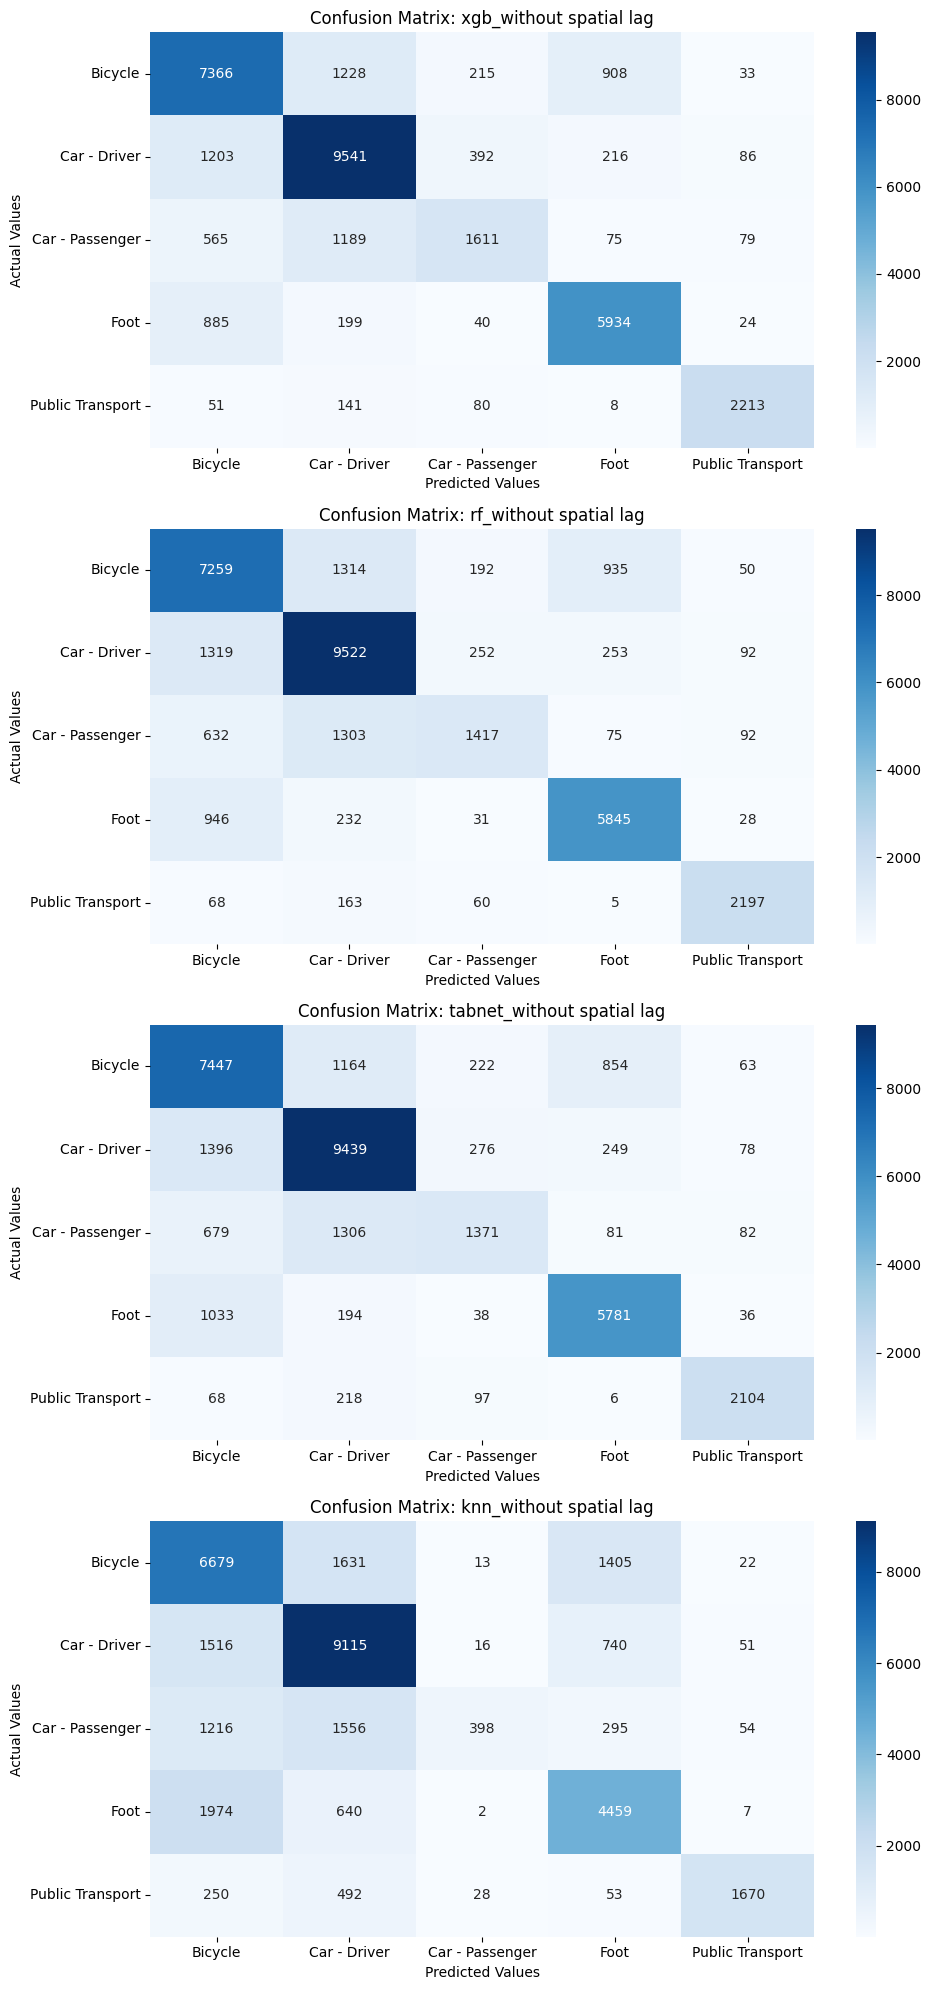

In [17]:
mapping = {'Bicycle':0, 'Car - Driver':1, 'Car - Passenger':2, 'Foot':3,
       'Public Transport':4}

def conf_matrix(y_true, y_pred, title, ax):
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=mapping.keys(), columns=mapping.keys())
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    

fig, axes = plt.subplots(4, 1, figsize=(10, 20)) 

conf_matrix(y_test, y_pred_xgb_baseline, title="Confusion Matrix: xgb_without spatial lag", ax=axes[0])  
conf_matrix(y_test, y_pred_rf_baseline, title="Confusion Matrix: rf_without spatial lag", ax=axes[1])  
conf_matrix(y_test, y_pred_tabnet_baseline, title="Confusion Matrix: tabnet_without spatial lag", ax=axes[2])  
conf_matrix(y_test, y_pred_knn_baseline, title="Confusion Matrix: knn_without spatial lag", ax=axes[3])  

plt.tight_layout()  
plt.savefig("confusion_matrices_baseline.pdf")
plt.show()


<a id='section13'></a>
# Feature_Importance_RF+XGB_TabNet
[Back to Table of Contents](#Table-of-Contents)

In [12]:
# part of this code is from: https://www.kaggle.com/code/optimo/tabnet-with-loop-feature-engineering-explained
from pytorch_tabnet.tab_model import TabNetClassifier
tabnet_parm =joblib.load('study_tabnet.pkl')
tabnet_params = { 'mask_type': 'entmax','n_d': 10,  'gamma': 1.0, "n_steps":3,
    'n_shared': 4, 'lambda_sparse': 0.0003665999408830711, 'device_name': 'cuda'}
tabnet_classifier = TabNetClassifier(**tabnet_params)
                 
tabnet_classifier.fit(X_train_top_mi, y_train_split)
feature_importance_tabnet = tabnet_classifier.feature_importances_

feature_importance_tabnet_df = pd.DataFrame(feature_importance_tabnet, index=selected_feature_rfecv, columns=['Importance'])
feature_importance_tabnet_df =feature_importance_tabnet_df.sort_values("Importance", ascending=False)
feature_importance_tabnet_df


feature_importance_tabnet_df.to_csv("feature_importance_tabnet.csv")
print(feature_importance_tabnet_df)

epoch 0  | loss: 1.21051 |  0:00:30s
epoch 1  | loss: 0.76109 |  0:00:55s
epoch 2  | loss: 0.63905 |  0:01:20s
epoch 3  | loss: 0.60596 |  0:01:46s
epoch 4  | loss: 0.5884  |  0:02:11s
epoch 5  | loss: 0.57477 |  0:02:36s
epoch 6  | loss: 0.57428 |  0:03:01s
epoch 7  | loss: 0.56227 |  0:03:28s
epoch 8  | loss: 0.55571 |  0:03:54s
epoch 9  | loss: 0.55056 |  0:04:21s
epoch 10 | loss: 0.54676 |  0:04:48s
epoch 11 | loss: 0.54563 |  0:05:14s
epoch 12 | loss: 0.53902 |  0:05:41s
epoch 13 | loss: 0.54108 |  0:06:08s
epoch 14 | loss: 0.5391  |  0:06:35s
epoch 15 | loss: 0.53353 |  0:07:01s
epoch 16 | loss: 0.53333 |  0:07:28s
epoch 17 | loss: 0.5284  |  0:07:55s
epoch 18 | loss: 0.52842 |  0:08:22s
epoch 19 | loss: 0.52788 |  0:08:48s
epoch 20 | loss: 0.52402 |  0:09:16s
epoch 21 | loss: 0.52404 |  0:09:44s
epoch 22 | loss: 0.51976 |  0:10:12s
epoch 23 | loss: 0.52224 |  0:10:40s
epoch 24 | loss: 0.52007 |  0:11:08s
epoch 25 | loss: 0.5186  |  0:11:36s
epoch 26 | loss: 0.51628 |  0:12:04s
e

In [14]:
from xgboost import XGBClassifier
xgb_params = joblib.load('study_xgb.pkl')
xgb_classifier = XGBClassifier(**xgb_params.best_params)
xgb_classifier.fit(X_train_top_mi, y_train_split)
y_pred_xgb_baseline = xgb_classifier.predict(X_test_top_mi)


feature_importance = xgb_classifier.feature_importances_

feature_importance_xgb = pd.DataFrame(feature_importance, index=selected_feature_rfecv).sort_values(0, ascending=False)
feature_importance_xgb.to_csv("feature_importance_xgb.csv")
feature_importance_xgb


,0
License,0.235216
NumberOfTripLegs,0.207944
PCA_dr_wl_cl_duration_1,0.087852
TripPurpose_Subsistence Activities,0.053125
TripLegDistance,0.047833
FrequencyOfUseOfNonEelectricBicycle,0.044630
TotalTravelDuration,0.039904
FrequencyOfUsecarAsAPassenger,0.033891
NumberOfCarsInHousehold,0.029601
PCA_dr_wl_cl_duration_2,0.023533


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf_parm =joblib.load('study_rf.pkl')

rf_classifier = RandomForestClassifier(**rf_parm.best_params)
rf_classifier.fit(X_train_top_mi, y_train_split)





y_pred_prob_xgb_baseline = rf_classifier.predict_proba(X_test_top_mi)
y_pred_xgb_baseline = rf_classifier.predict(X_test_top_mi)

feature_importance = rf_classifier.feature_importances_



feature_importance_rf = pd.DataFrame(feature_importance, index=selected_feature_rfecv).sort_values(0, ascending=False)
feature_importance_rf.to_csv("feature_importance_rf.csv")
feature_importance_rf 

,0
PCA_dr_wl_cl_duration_1,0.223147
TripLegDistance,0.148665
NumberOfTripLegs,0.148381
TotalTravelDuration,0.082092
License,0.071188
FrequencyOfUseOfNonEelectricBicycle,0.050865
FrequencyOfUsecarAsAPassenger,0.022976
LatitudeLiving,0.018053
SurroundingAddressDensity,0.017939
LongitudeLiving,0.017446


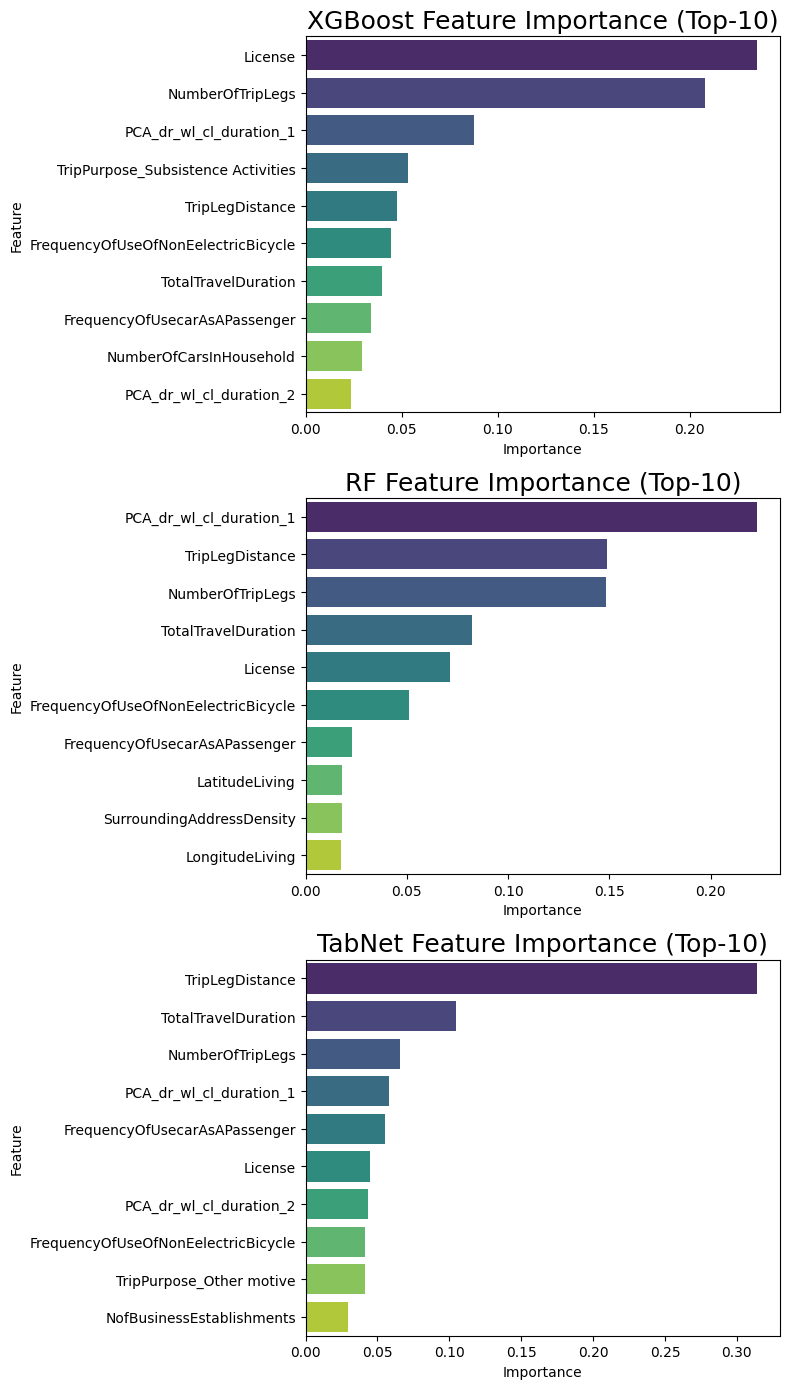

In [26]:
plt.figure(figsize=(8, 14))

plt.subplot(311) 
sns.barplot(y=feature_importance_xgb.index[0:10], x=feature_importance_xgb.iloc[0:10, 0],  palette="viridis")
plt.title('XGBoost Feature Importance (Top-10)', fontsize=18)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tick_params(axis='y', labelsize=10)


plt.subplot(312) 
sns.barplot(y=feature_importance_rf.index[0:10], x=feature_importance_rf.iloc[0:10, 0],  palette="viridis")
plt.title('RF Feature Importance (Top-10)', fontsize=18)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tick_params(axis='y', labelsize=10)

plt.subplot(313) 
sns.barplot(y=feature_importance_tabnet_df.index[0:10], x=feature_importance_tabnet_df.iloc[0:10, 0], palette="viridis")
plt.title('TabNet Feature Importance (Top-10)', fontsize=18)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig('xgb_rf_tabnet-feature', bbox_inches='tight')
plt.show()


In [19]:
# https://shengyg.github.io/repository/machine%20learning/2017/02/25/Complete-Guide-to-Parameter-Tuning-xgboost.html tuning xgboost why
feature_importance_rf.iloc[0:10].index

Index(['PCA_dr_wl_cl_duration_1', 'TripLegDistance', 'NumberOfTripLegs',
       'TotalTravelDuration', 'License', 'FrequencyOfUseOfNonEelectricBicycle',
       'FrequencyOfUsecarAsAPassenger', 'LatitudeLiving',
       'SurroundingAddressDensity', 'LongitudeLiving'],
      dtype='object')

In [32]:
# this function is  from:  https://www.geeksforgeeks.org/how-to-calculate-jaccard-similarity-in-python/
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union
 

# top 10 featues
print("Jaccard Similarity RF & TabNet:", jaccard_similarity(feature_importance_rf.iloc[0:10].index, feature_importance_tabnet_df.iloc[0:10].index))
print("Jaccard Similarity RF & XGBoost:", jaccard_similarity(feature_importance_rf.iloc[0:10].index, feature_importance_xgb.iloc[0:10].index))
print("Jaccard Similarity XGBoost & TabNet:", jaccard_similarity(feature_importance_xgb.iloc[0:10].index, feature_importance_tabnet_df.iloc[0:10].index))

Jaccard Similarity RF & TabNet: 0.5384615384615384
Jaccard Similarity RF & XGBoost: 0.5384615384615384
Jaccard Similarity XGBoost & TabNet: 0.6666666666666666


In [33]:
# this function is  from:  https://www.geeksforgeeks.org/how-to-calculate-jaccard-similarity-in-python/
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union
 
# top 20 features
print("Jaccard Similarity RF & TabNet:", jaccard_similarity(feature_importance_rf.iloc[0:20].index, feature_importance_tabnet_df.iloc[0:20].index))
print("Jaccard Similarity RF & XGBoost:", jaccard_similarity(feature_importance_rf.iloc[0:20].index, feature_importance_xgb.iloc[0:10].index))
print("Jaccard Similarity XGBoost & TabNet:", jaccard_similarity(feature_importance_xgb.iloc[0:20].index, feature_importance_tabnet_df.iloc[0:20].index))

Jaccard Similarity RF & TabNet: 0.3333333333333333
Jaccard Similarity RF & XGBoost: 0.36363636363636365
Jaccard Similarity XGBoost & TabNet: 0.7391304347826086
